<a href="https://colab.research.google.com/github/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [1]:
!pip install emoji

In [2]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [3]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

fatal: destination path 'word_cloud' already exists and is not an empty directory.
/content/word_cloud
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.8.0.post1+g5f23ed4-cp36-cp36m-linux_x86_64.whl size=338647 sha256=a2e30760902971009d51b19043e03c161a816201e0fbdedacc534e9a48bf0690
  Stored in directory: /tmp/pip-ephem-wheel-cache-ap9tu2xt/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.8.0.post1+g5f23ed4
    Uninstalling wordcloud-1.8.0.post1+g5f23ed4:
      Successfully uninstalled wordcloud-1.8.0.post1+g5f23ed4


# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [4]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+) ([0-9]+):([0-9]+)' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [5]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [6]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message


If you get a **Value Error** after running the below cell , it may be due to different format of date.

Try replacing %d-%m-%Y with %m-%d-%Y and replacing %d-%m-%y with %m-%d-%y and similarly for / too.

In [7]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return date[6:] + "-" + date[3:5] + "-" + date[:2]
    if len(year) ==2:
      return date[6:] + "-" + date[3:5] + "-" + date[:2]

In [8]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

Change file path in the below cell

In [9]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

04/06/2019 17:52 - As mensagens e as chamadas são protegidas com a criptografia de ponta a ponta e ficam somente entre você e os participantes desta conversa. Nem mesmo o WhatsApp pode ler ou ouvi-las. Toque para saber mais.



In [10]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["DateAux"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [11]:
df.head(5)

,Date,Time,Author,Message,DateAux,emoji,urlcount
2,2019-04-06,17:55,Fulano1,<Arquivo de mídia oculto>,2019-06-04,[],0
3,2019-04-06,17:57,Beltrano1,"""Camelas"" ????",2019-06-04,[],0
4,2019-04-06,17:57,Beltrano1,😂😂,2019-06-04,"[😂, 😂]",0
5,2019-04-06,17:57,Beltrano1,<Arquivo de mídia oculto>,2019-06-04,[],0
7,2019-04-06,17:58,Beltrano1,Kkkkkk,2019-06-04,[],0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31678 entries, 2 to 31774
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      31678 non-null  datetime64[ns]
 1   Time      31678 non-null  object        
 2   Author    31678 non-null  object        
 3   Message   31678 non-null  object        
 4   DateAux   31678 non-null  object        
 5   emoji     31678 non-null  object        
 6   urlcount  31678 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.9+ MB


## Printing Participants

In [13]:
df.Author.unique()

array(['Fulano1', 'Beltrano1', 'Sicrano1 ', 'Fulano2', 'Beltrano2',
       'Sicrano2', 'Fulano3', 'Beltrano3', 'Sicrano3', 'Fulano4',
       'Sicrano4', 'Fulano5', 'Beltrano4'], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [14]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31678 entries, 2 to 31774
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      31678 non-null  datetime64[ns]
 1   Time      31678 non-null  object        
 2   Author    31678 non-null  object        
 3   Message   31678 non-null  object        
 4   DateAux   31678 non-null  object        
 5   emoji     31678 non-null  object        
 6   urlcount  31678 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.9+ MB


In [15]:
df.Author.unique()

array(['Fulano1', 'Beltrano1', 'Sicrano1 ', 'Fulano2', 'Beltrano2',
       'Sicrano2', 'Fulano3', 'Beltrano3', 'Sicrano3', 'Fulano4',
       'Sicrano4', 'Fulano5', 'Beltrano4'], dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [16]:
total_messages = df.shape[0]
print(total_messages)

31678


Let us now find out the total Media Messages

In [17]:
media_messages = df[df['Message'] == ' <Arquivo de mídia oculto>'].shape[0]
print(media_messages)

9390


In [18]:
emojis = sum(df['emoji'].str.len())
print(emojis)

25089


In [19]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [20]:
links = np.sum(df.urlcount)

In [21]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 31678
Media: 9390
Emojis: 25089
Links: 88


## Let us Separate the media messages and text messages

In [22]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " Essa mensagem foi apagada")| (df["Message"] == " você apagou essa mensagem")]
media_messages_df = df[(df['Message'] == ' <Arquivo de mídia oculto>')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [23]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21885 entries, 3 to 31773
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      21885 non-null  datetime64[ns]
 1   Time      21885 non-null  object        
 2   Author    21885 non-null  object        
 3   Message   21885 non-null  object        
 4   DateAux   21885 non-null  object        
 5   emoji     21885 non-null  object        
 6   urlcount  21885 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.3+ MB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [24]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [25]:
messages_df.head(5)

,Date,Time,Author,Message,DateAux,emoji,urlcount,Letter_Count,Word_Count,MessageCount
3,2019-04-06,17:57,Beltrano1,"""Camelas"" ????",2019-06-04,[],0,15,3,1
4,2019-04-06,17:57,Beltrano1,😂😂,2019-06-04,"[😂, 😂]",0,3,2,1
7,2019-04-06,17:58,Beltrano1,Kkkkkk,2019-06-04,[],0,7,2,1
9,2019-04-06,17:58,Beltrano1,🤣🤣🤣🤣🤣,2019-06-04,"[🤣, 🤣, 🤣, 🤣, 🤣]",0,6,2,1
10,2019-04-06,17:58,Fulano1,🤣🤣🤣🤣🤣🤣,2019-06-04,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",0,7,2,1


In [26]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [27]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == l[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Beltrano1 -
Messages Sent 1787
Words per message 5.175153889199776
Media Messages Sent 691
Emojis Sent 1349
Links Sent 4

Stats of Fulano1 -
Messages Sent 4647
Words per message 3.971594577146546
Media Messages Sent 2600
Emojis Sent 6261
Links Sent 27

Stats of Fulano2 -
Messages Sent 1996
Words per message 6.934869739478958
Media Messages Sent 678
Emojis Sent 2609
Links Sent 3

Stats of Sicrano1  -
Messages Sent 3048
Words per message 4.900590551181103
Media Messages Sent 831
Emojis Sent 2745
Links Sent 6

Stats of Beltrano2 -
Messages Sent 2
Words per message 4.0
Media Messages Sent 0
Emojis Sent 3
Links Sent 0

Stats of Sicrano2 -
Messages Sent 172
Words per message 8.813953488372093
Media Messages Sent 29
Emojis Sent 235
Links Sent 1

Stats of Fulano3 -
Messages Sent 2289
Words per message 4.121450415028397
Media Messages Sent 351
Emojis Sent 2996
Links Sent 1

Stats of Beltrano3 -
Messages Sent 5783
Words per message 5.223759294483832
Media Messages Sent 2272
Emojis Sent 

# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [28]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

462


### Most used emoji

In [29]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('🤣', 2474), ('🙏🏻', 2129), ('😂', 1910), ('😍', 1316), ('👏', 1193), ('🙏', 902), ('🙏🏼', 849), ('👏🏻', 816), ('❤', 779), ('\U0001f970', 673), ('😭', 588), ('👏🏽', 530), ('🙌🏻', 498), ('🙌', 462), ('👏🏼', 458), ('😋', 450), ('🙊', 412), ('❤️', 336), ('😱', 319), ('😔', 269), ('💔', 267), ('\U0001f97a', 248), ('❣️', 248), ('😘', 240), ('\U0001f92d', 199), ('😴', 197), ('👀', 168), ('🙄', 159), ('💕', 156), ('🤔', 141), ('🎂', 136), ('\U0001f973', 132), ('😩', 132), ('😢', 128), ('😓', 121), ('🙏🏽', 114), ('💞', 107), ('♥️', 105), ('🙌🏼', 103), ('🎉', 96), ('💙', 90), ('🤦🏻\u200d♀️', 86), ('😝', 82), ('👍', 79), ('💥', 78), ('😷', 76), ('😆', 73), ('😡', 72), ('😫', 69), ('🌹', 69), ('\U0001f971', 68), ('🤗', 65), ('😰', 64), ('😅', 62), ('🙈', 62), ('\U0001f974', 60), ('🤤', 58), ('🙉', 57), ('😥', 55), ('😒', 53), ('💚', 52), ('😞', 48), ('😣', 48), ('🍻', 47), ('\U0001f929', 46), ('👍🏻', 44), ('☝️', 40), ('🛵', 39), ('😉', 38), ('🌚', 38), ('🤐', 37), ('🤦🏼\u200d♀', 37), ('😁', 36), ('🔥', 36), ('🙌🏽', 34), ('💗', 34), ('😟', 33), ('🎈', 32), ('\

In [30]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,🤣,2474
1,🙏🏻,2129
2,😂,1910
3,😍,1316
4,👏,1193
...,...,...
457,✝️,1
458,🤚,1
459,💟,1
460,✌,1


We can see '🤣'   dominates the list.

### Emoji distribution visualisation

In [31]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [32]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Distribuição de Emoji para: ', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Distribuição de Emoji para:  Beltrano1


Distribuição de Emoji para:  Fulano1


Distribuição de Emoji para:  Fulano2


Distribuição de Emoji para:  Sicrano1 


Distribuição de Emoji para:  Beltrano2


Distribuição de Emoji para:  Sicrano2


Distribuição de Emoji para:  Fulano3


Distribuição de Emoji para:  Beltrano3


Distribuição de Emoji para:  Sicrano3


Distribuição de Emoji para:  Fulano4


Distribuição de Emoji para:  Sicrano4


Distribuição de Emoji para:  Fulano5


Distribuição de Emoji para:  Beltrano4


# Some more Stats



```
# Isto está formatado como código
```

### **Day wise Distribution**

In [33]:
def f(i):
  l = ["Segunda", "Terca", "Quarta", "Quinta", "Sexta", "Sabado", "Domingo"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [34]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [35]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [36]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [37]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta", 
                                      "black", "grey", "violet", "brown", "silver", 
                                      "yellow", "orange", "purple"],
             title="Explicit color sequence"
            )

fig.show()


### **When are the group members most active?**

Text(0, 0.5, 'Tempo')

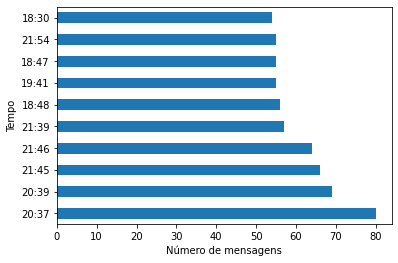

In [38]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Número de mensagens')
plt.ylabel('Tempo')

### **The most happening day was -**

2020-05-12    328
2020-04-08    206
2020-06-11    193
2020-05-15    192
2019-07-22    184
             ... 
2020-09-25      4
2020-08-24      2
2020-04-25      2
2020-08-30      2
2019-11-17      2
Name: DateAux, Length: 512, dtype: int64


Text(0, 0.5, 'Data')

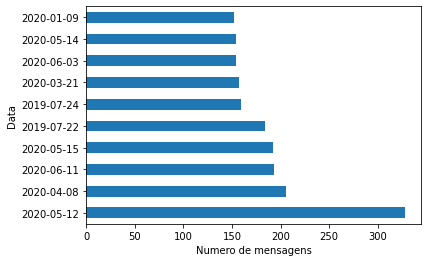

In [39]:
messages_df['DateAux'].value_counts().head(10).plot.barh()
print(messages_df['DateAux'].value_counts())
plt.xlabel('Numero de mensagens')
plt.ylabel('Data')

### **The most shared websites**

Text(0, 0.5, 'website')

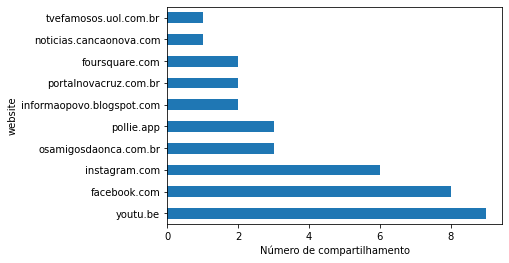

In [40]:
pattern_website = r'https?://([\w\-\.]+)'
mensagens = df['Message']

mensagens = mensagens[mensagens.str.contains('https?://[\w\-\.]+',  flags=re.I)]
domains = mensagens.str.extract(pattern_website, flags=re.I)
series_website = domains.iloc[:,0]
series_website = series_website.str.replace("www.", "")
series_website.value_counts().head(10).plot.barh()
plt.xlabel('Número de compartilhamento')
plt.ylabel('website')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [41]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-05-10 00:00:00
Time                                                        18:23
Author                                                    Fulano1
Message          NOTA DE CUNHO INFORMATIVO!  Prezados(a) boa t...
DateAux                                                2020-10-05
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2326
Word_Count                                                    390
MessageCount                                                    1
emojicount                                                      0
Name: 30848, dtype: object

### **Word Cloud**

In [42]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 490665 words in all the messages.


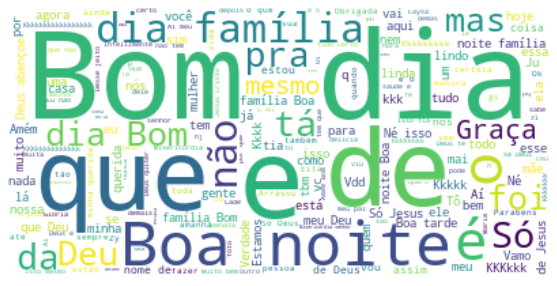

In [43]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

###**Author Wise Wordcloud**

In [44]:
# l = messages_df.Author.unique()
# for i in range(len(l)):
#   dummy_df = messages_df[messages_df['Author'] == l[i]]
#   text = " ".join(review for review in dummy_df.Message)
#   stopwords = set(STOPWORDS)
#   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
#   # Generate a word cloud image
#   print('Author name',l[i])
#   wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
#   # Display the generated image:
#   # the matplotlib way:
  
#   plt.figure( figsize=(10,5))
#   plt.imshow(wordcloud, interpolation='bilinear')
#   plt.axis("off")
#   plt.show()

In [45]:
""

''